# KDE sensitivity analysis

This notebook is intended to reproduce the interval statistics sensitivity analysis tests. This is done by varying the choice of interval size for both the median value method and the difference between median values method. Further description of how this is done can be found below.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats.mstats import mquantiles
from scipy.stats import zscore, ttest_ind
import pyleoclim as pyleo

In [2]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

#Sort by latitude

lat_dict = {pos_dict[label]['lat']:label for label in holo_chrons.keys()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
holo_chrons = {label:holo_chrons[label] for label in sort_label} #Sort by latitude
pos_dict = {label:pos_dict[label] for label in sort_label}

First we do this using the median interval values themselves. We generate histograms of median interval values for each interval size, and collect the median value for the 4ka interval in `interval_dict`.

In [3]:
# Detrending and collect d18O values at different intervals

# d18O values at different intervals
d18O_int = {}

# Detrended zscore vals
zscore_detrend = {}

# d18O values over the 4ka interval
interval_dict = {}

# Iterate over each site in holo_chrons
for site in holo_chrons.keys():
    # Get the d18O values and convert to float
    ty = holo_chrons[site]['d18O'].astype(float)
    
    # Get the chronology values and convert to float
    chron_tmp = holo_chrons[site]['chron'].astype(float)
    
    nC = 1000
    
    # Initialize zscore_detrend for the current site with NaN values
    zscore_detrend[site] = np.zeros((nC, len(ty)))
    zscore_detrend[site][:] = np.nan
    
    # Iterate over the range of nC
    for j in range(nC):
        # Get the chronology values for the current iteration
        tx = chron_tmp[j, :]
        
        # Create a Pyleoclim Series object with the chronology and d18O values
        ts = pyleo.Series(time=tx, value=ty, dropna=False,verbose=False)
        
        # Detrend the Series using the Savitzky-Golay method
        ts_detrended = ts.detrend(method='savitzky-golay')
        
        # Get the detrended values
        a = ts_detrended.value
        
        # Calculate the zscore of the detrended values and store in zscore_detrend
        zscore_detrend[site][j, :] = zscore(a, nan_policy='omit')
    
    # Initialize dictionaries for the current site
    d18O_int[site] = {}
    interval_dict[site] = []
    holo_int = {}
    
    # Iterate over different interval sizes
    for int_size in [50, 100, 150, 200, 250, 300]:
        # Calculate the interval boundaries based on the interval size
        holo_int[int_size] = np.arange(4000 % int_size - int_size / 2, 10000, int_size)
        
        # Initialize d18O_int for the current site and interval size with NaN values
        d18O_int[site][int_size] = np.zeros((len(holo_int[int_size]) - 1, nC))
        d18O_int[site][int_size][:] = np.nan
        
        # Iterate over the interval boundaries
        for idx, tage in enumerate(holo_int[int_size][:-1]):
            # Iterate over the range of nC
            for j in range(nC):
                # Get the chronology values for the current iteration
                tx = chron_tmp[j, :]
                
                # Calculate the median of zscore_detrend for the current interval and store in d18O_int
                d18O_int[site][int_size][idx, j] = np.nanmedian(zscore_detrend[site][j, (tx >= tage) & (tx < holo_int[int_size][idx + 1])])
        
        # Iterate over the columns of d18O_int for the current site and interval size
        for i in range(d18O_int[site][int_size].shape[1]):
            # Append the d18O values at the 4ka interval to interval_dict
            interval_dict[site].append(d18O_int[site][int_size][holo_int[int_size][:-1] == 4000 - int_size / 2, i])

/Users/alexjames/GitHub/Pyleoclim_util/pyleoclim/utils/tsutils.py:1417: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_19990/2380489624.py:65: RuntimeWarning: All-NaN slice encountered
  d18O_int[site][int_size][idx, j] = np.nanmedian(zscore_detrend[site][j, (tx >= tage) & (tx < holo_int[int_size][idx + 1])])
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty s

Then, instead of plotting a single KDE + vertical shading for median interval values over the 4ka interval, we plot all of the KDEs (for each interval size), with shorter intervals indicated by a lower alpha value (more transparency). We also plot the interquartile range for 4 ka interval values from all of the different interval sizes. The inner grey dashed line indicates the median, and the outer solid lines indicate the 25th and 75th percentile respectively.

/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

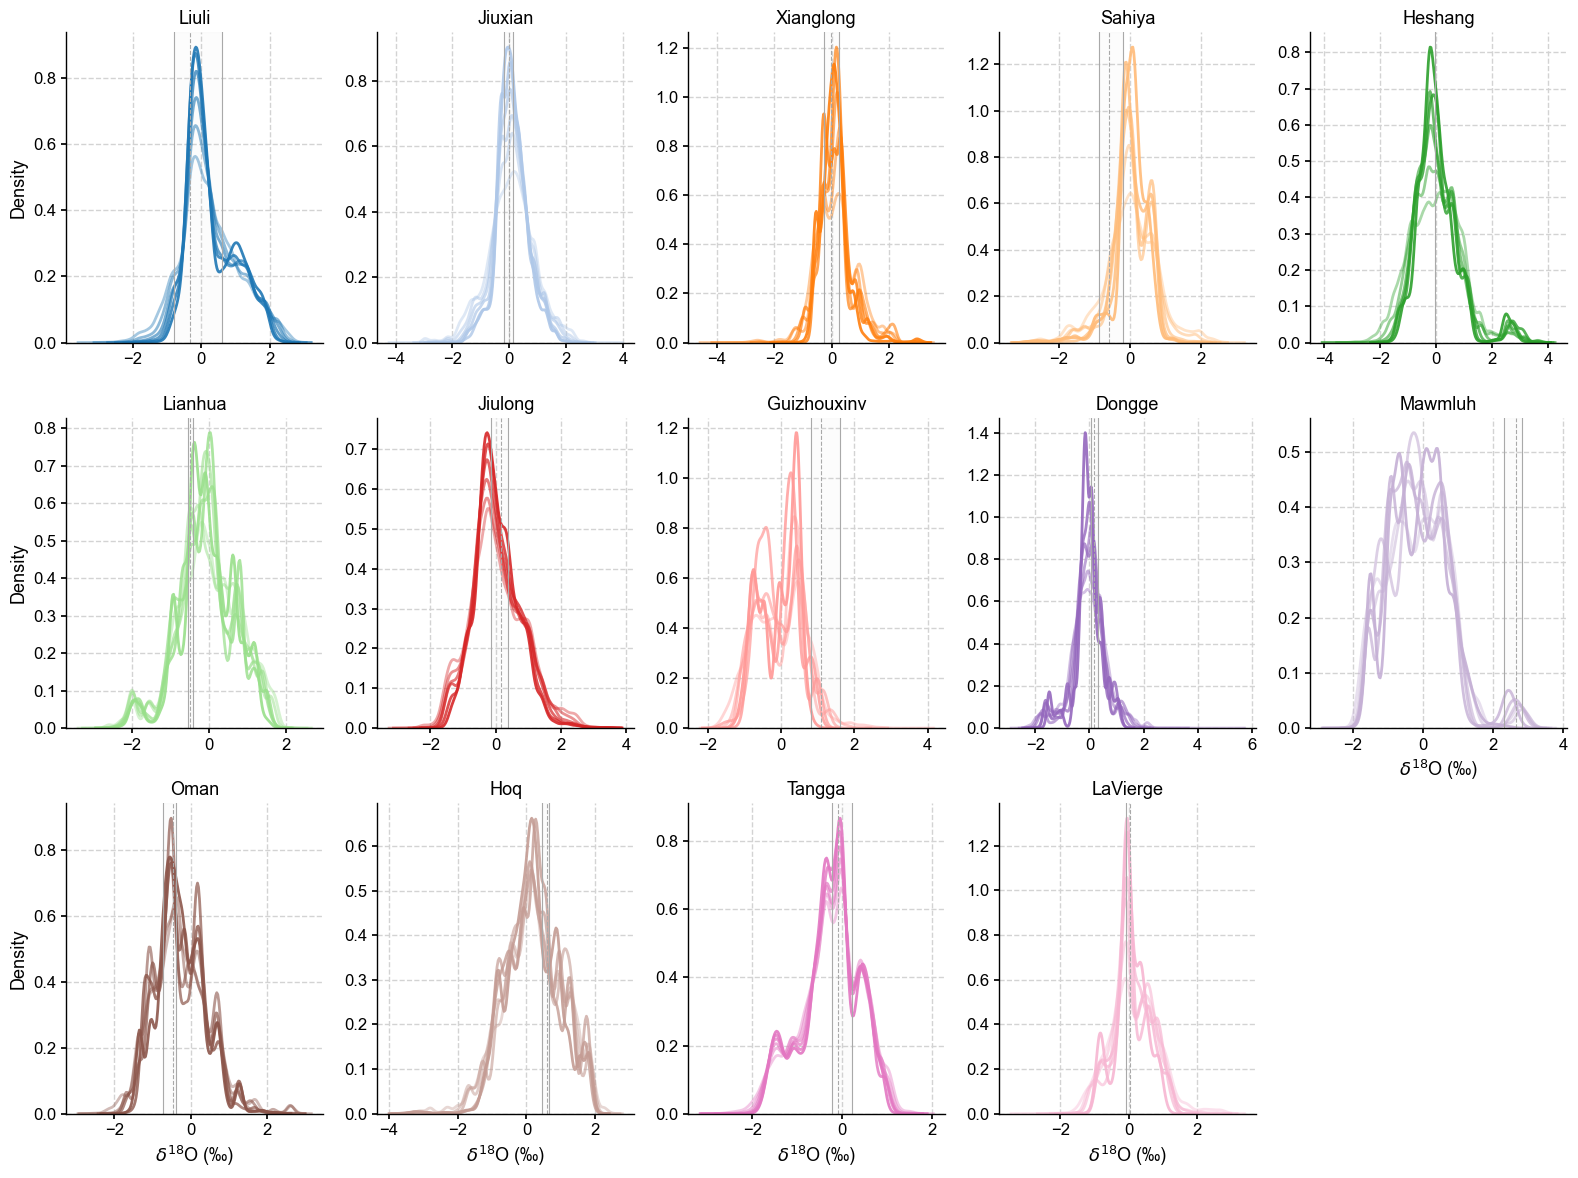

In [4]:
# Set color palette based on the number of keys in holo_chrons
clrs = sns.color_palette(palette='tab20', n_colors=len(holo_chrons.keys()) + 1)

# Create a figure with 5 columns and 3 rows of subplots
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 12), tight_layout=True)

# Flatten the 2D array of axes into a 1D array
axes = ax.ravel()

# Define the quantiles to calculate
quants = [.25, .5, .75]

# Iterate over each site in holo_chrons
for idx, site in enumerate(holo_chrons.keys()):
   # Iterate over different interval sizes
   for idy, int_size in enumerate([50, 100, 150, 200, 250, 300]):
       # Create a pandas Series from the flattened d18O_int for the current site and interval size
       s = pd.Series(d18O_int[site][int_size].flatten())
       
       # Plot a KDE for the current site and interval size
       sns.kdeplot(s.dropna(), color=clrs[idx], ax=axes[idx], alpha=(idy + 4) / 10)
       
       # Set the title of the subplot for the first interval size
       if idy == 0:
           axes[idx].set_title(site, fontsize=13)
       
       # Set the tick label size for both axes
       axes[idx].tick_params(axis='both', which='major', labelsize=12)
   
   # Get the interval statistics for the current site
   interval_stats = interval_dict[site]
   
   # Calculate the quantiles for the interval statistics
   interval_quantiles = mquantiles(interval_stats, prob=quants)
   
   # Iterate over the calculated quantiles
   for idz, q in enumerate(interval_quantiles):
       # Set the linestyle based on the quantile index
       if int(idz) in [0, 2]:
           linestyle = 'solid'
       else:
           linestyle = 'dashed'
       
       # Add a vertical line at the quantile value
       axes[idx].axvline(x=q, alpha=1, color='darkgray', linewidth=.8, linestyle=linestyle)
   
   # Add a vertical span between the first and third quantiles
   axes[idx].axvspan(interval_quantiles[0], interval_quantiles[2], color='gray', alpha=0.02)
   
   # Set the y-label for specific subplots
   if idx in [0, 5, 10]:
       axes[idx].set_ylabel('Density', fontsize=13)
   else:
       axes[idx].set_ylabel('')
   
   # Set the x-label for the bottom row of subplots
   if idx >= 9:
       axes[idx].set_xlabel(u'$\delta^{18}$O (\u2030)', fontsize=13)

# Remove the last unused subplot
fig.delaxes(axes[-1])

In [5]:
pyleo.savefig(fig,'../figures/interval_4k_dist_sensitivity.pdf')

Figure saved at: "../../figures/interval_4k_dist_sensitivity.pdf"


We then do the same as above, using the difference between median interval values as opposed to the median interval values themselves.

In [6]:
# Initialize dictionaries to store d18O differences and interval differences
d18O_diff = {}
interval_diff_dict = {}

# Iterate over each site in d18O_int
for site in d18O_int:
    # Initialize nested dictionaries for the current site
    d18O_diff[site] = {}
    interval_diff_dict[site] = []
    
    # Iterate over different interval sizes
    for int_size in [50, 100, 150, 200, 250, 300]:
        # Calculate the differences along the first axis (rows) of d18O_int for the current site and interval size
        d18O_diff[site][int_size] = np.diff(d18O_int[site][int_size], axis=0)
        
        # Iterate over the columns of d18O_diff for the current site and interval size
        for i in range(d18O_diff[site][int_size].shape[1]):
            # Append the d18O differences at the 4ka interval to interval_diff_dict
            interval_diff_dict[site].append(d18O_diff[site][int_size][holo_int[int_size][1:-1] == 4000 - int_size / 2, i])

/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

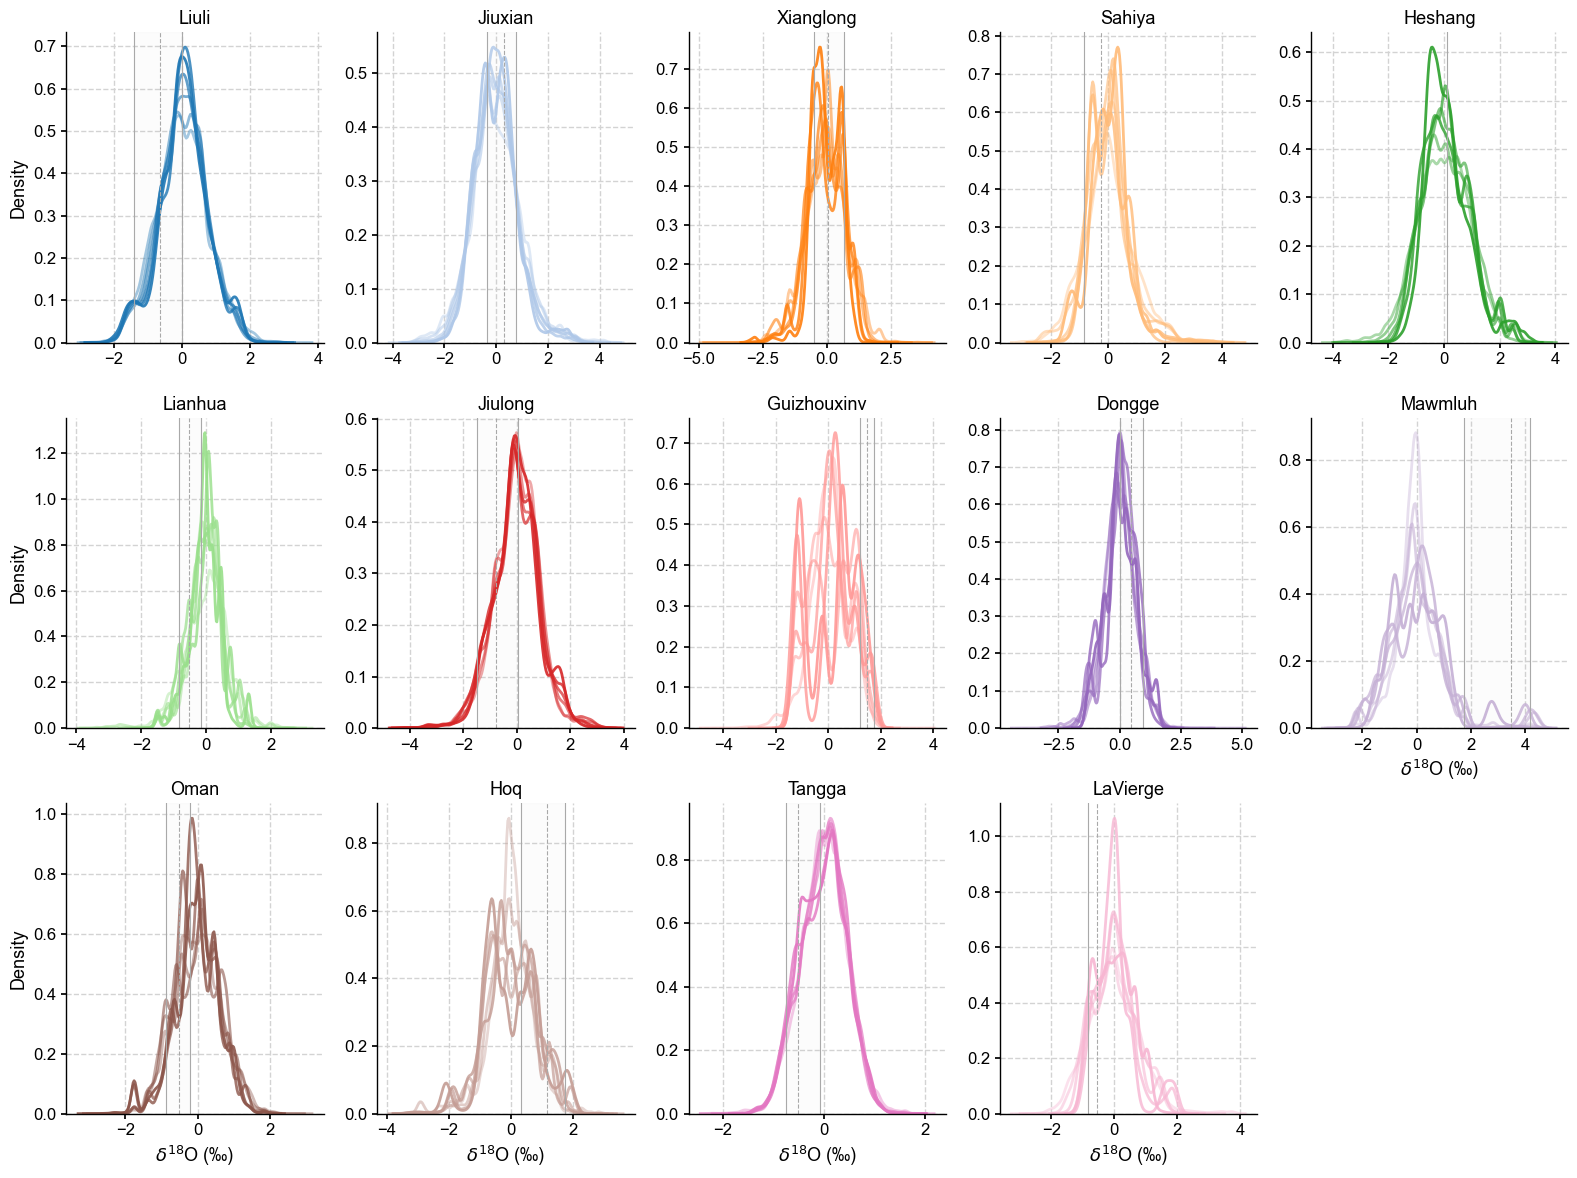

In [7]:
# Set color palette based on the number of keys in holo_chrons
clrs = sns.color_palette(palette='tab20', n_colors=len(holo_chrons.keys()) + 1)

# Create a figure with 5 columns and 3 rows of subplots
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16, 12), tight_layout=True)

# Flatten the 2D array of axes into a 1D array
axes = ax.ravel()

# Define the quantiles to calculate
quants = [.25, .5, .75]

# Iterate over each site in holo_chrons
for idx, site in enumerate(holo_chrons.keys()):
    # Iterate over different interval sizes
    for idy, int_size in enumerate([50, 100, 150, 200, 250, 300]):
        # Create a pandas Series from the flattened d18O_diff for the current site and interval size
        s = pd.Series(d18O_diff[site][int_size].flatten())
        
        # Plot a KDE for the current site and interval size
        sns.kdeplot(s.dropna(), color=clrs[idx], ax=axes[idx], alpha=(idy + 4) / 10)
        
        # Set the title of the subplot for the first interval size
        if idy == 0:
            axes[idx].set_title(site, fontsize=13)
        
        # Set the tick label size for both axes
        axes[idx].tick_params(axis='both', which='major', labelsize=12)
    
    # Get the interval statistics for the current site
    interval_stats = interval_diff_dict[site]
    
    # Calculate the quantiles for the interval statistics
    interval_quantiles = mquantiles(interval_stats, prob=quants)
    
    # Iterate over the calculated quantiles
    for idz, q in enumerate(interval_quantiles):
        # Set the linestyle based on the quantile index
        if int(idz) in [0, 2]:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        # Add a vertical line at the quantile value
        axes[idx].axvline(x=q, alpha=1, color='darkgray', linewidth=.8, linestyle=linestyle)
    
    # Add a vertical span between the first and third quantiles
    axes[idx].axvspan(interval_quantiles[0], interval_quantiles[2], color='gray', alpha=0.02)
    
    # Set the y-label for specific subplots
    if idx in [0, 5, 10]:
        axes[idx].set_ylabel('Density', fontsize=13)
    else:
        axes[idx].set_ylabel('')
    
    # Set the x-label for the bottom row of subplots
    if idx >= 9:
        axes[idx].set_xlabel(u'$\delta^{18}$O (\u2030)', fontsize=13)

# Remove the last unused subplot
fig.delaxes(axes[-1])

In [8]:
pyleo.savefig(fig,'../../figures/interval_4k_diff_sensitivity.pdf')

Figure saved at: "../../figures/interval_4k_diff_sensitivity.pdf"
